<a href="https://colab.research.google.com/github/danjethh/steg_analysis/blob/main/how_steg_works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from scipy.ndimage import sobel
from scipy.stats import skew, kurtosis
import pywt
from scipy import ndimage
from scipy.stats import pearsonr
import pandas as pd

### Step 1: Load Image and Display Image Type and Size
#### Purpose: Show an image consists of a set of pixel organized in a 2D array

#### Input:
- The link to the image.

#### Output:
- Displays the original image in grayscale.
- Prints information about:
  - The image size (e.g., 512 x 512 pixels)
  - The image format (e.g., PGM, JPG)

- Also converts the image into a grid of brightness values (pixel array) for later steps.

#### Description:
This function does three things:

1. **Downloads the image** from the internet.
2. **Displays the image** in black and white (grayscale).
3. **Prints metadata**, which includes:
   - The file format used to store the image (like PGM)
   - The total width and height (in pixels)


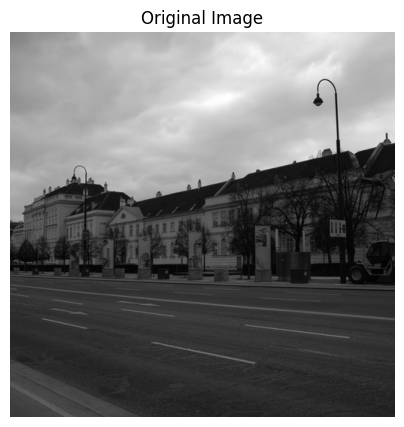

Image Format into which messages can be inserted: PPM
Size in pixels: (512, 512)


In [ ]:
# Step 1
def load_image_and_metadata():
    image_url = "https://raw.githubusercontent.com/Sourish1997/steganalysis/master/bossbase_sample/14.pgm"
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    # Display image metadata
    print(f"Image Format into which messages can be inserted: {img.format}")
    print(f"Size in pixels: {img.size}")

    # Convert to NumPy grayscale array
    img_array = np.array(img)
    return img, img_array

# Step 1: Load image and metadata
img, img_array = load_image_and_metadata()

###Step 2: Display an Image in 2D Pixel Array

####Purpose:
  - Demonstrate that a Pixel is represented in interger (pixel intensity value) ranging from 0 to 255, which 0 represent white and 255 represent black. Numbers in between represent shades of gray

#### Input:
- A grayscale image.

#### Output:
- Prints the 2D array of pixel intensity value.
- Plot the frequency(how many) of each pixel intensity value.


Pixel Intensity (integer value of pixel) display in 2D with the size of 512x512:
[[128 128 126 ... 190 190 189]
 [128 128 128 ... 190 190 190]
 [128 129 129 ... 191 190 190]
 ...
 [ 57  57  59 ...  46  40  33]
 [ 59  57  58 ...  42  42  34]
 [ 60  55  57 ...  36  36  38]]


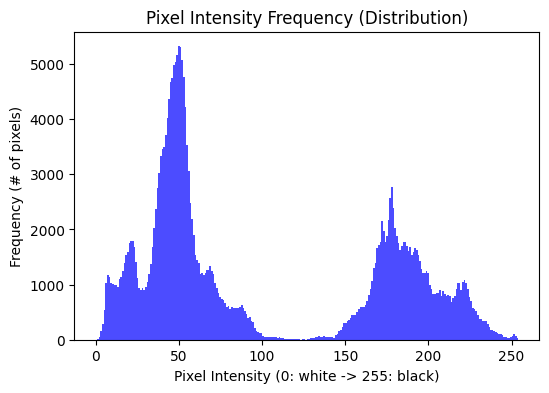

In [ ]:
# Step 2
def display_pixel_array_and_histogram(img_array):
    print("Pixel Intensity (integer value of pixel) display in 2D with the size of 512x512:")
    print(img_array)

    # Plotting pixel intensity histogram
    plt.figure(figsize=(6, 4))
    plt.hist(img_array.ravel(), bins=256, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Frequency (Distribution)')
    plt.xlabel('Pixel Intensity (0: white -> 255: black)')
    plt.ylabel('Frequency (# of pixels)')
    plt.show()

display_pixel_array_and_histogram(img_array)


### Step 3: Show the Binary of the Pixel 2D Intensity Array

**Purpose:**  
To convert the 2D pixel intensity values into their binary format for later use in message embedding and extraction.

**Input:**  
- A 2D array of pixel intensity values.

**Output:**  
- A 2D array showing the 8-bit binary representation of each pixel.

**Description:**  
This step transforms each pixel value (ranging from 0 to 255) into its 8-bit binary equivalent. The binary view reveals how pixel values are stored at the bit level, which is critical for understanding how messages can be hidden in the least significant bit (LSB) of each pixel.


In [ ]:
# Step 3
bit_representation = np.vectorize(np.binary_repr)(img_array, width=8)
print("Bit Representation of Pixel Intensity values in 2D with the size of 512x512:")
print(bit_representation)


Bit Representation of Pixel Intensity values in 2D with the size of 512x512:
[['10000000' '10000000' '01111110' ... '10111110' '10111110' '10111101']
 ['10000000' '10000000' '10000000' ... '10111110' '10111110' '10111110']
 ['10000000' '10000001' '10000001' ... '10111111' '10111110' '10111110']
 ...
 ['00111001' '00111001' '00111011' ... '00101110' '00101000' '00100001']
 ['00111011' '00111001' '00111010' ... '00101010' '00101010' '00100010']
 ['00111100' '00110111' '00111001' ... '00100100' '00100100' '00100110']]


### Step 4: Show message binary to be embedded into the Image

**Purpose:**  
Convert a text message into binary format in preparation for embedding into an image.

**Input:**  
- A plain text message (e.g., `"Secret"`)

**Output:**  
- The 8-bit binary representation of each character.
- A single binary string combining all characters.

**Description:**  
This step transforms each character in the message into its corresponding 8-bit binary value using ASCII encoding. The resulting binary bits are then concatenated into one continuous string, which will be embedded into the image using Least Significant Bit (LSB) steganography in the next step.


In [ ]:
# Step 4
message = "Secret"  # Define the hidden message
print(f"Message to be embedded: {message}")

# Convert message to binary character by character
message_bits = ''.join([format(ord(char), '08b') for char in message])
print("Each character of the message is represented in binary:")
for char in message:
    print(f"{char}: {format(ord(char), '08b')}")

print(f"Putting all binary together: {message_bits}")

Message to be embedded: Secret
Each character of the message is represented in binary:
S: 01010011
e: 01100101
c: 01100011
r: 01110010
e: 01100101
t: 01110100
Putting all binary together: 010100110110010101100011011100100110010101110100


### Step 5: Embed Message into Image using LSB Replacement

**Purpose:**  
Hide the binary message inside the image using the Least Significant Bit (LSB) technique.

**Input:**  
- A grayscale image (as a 2D grid of pixel intensity binary values).  
- A string of binary digits representing the message.

**Output:**  
- A new image that looks the same but secretly holds the message inside the pixel values.

**Description:**  
In this step, we hide the binary message inside the image by slightly adjusting the pixel values. Each bit from the message is stored in the last bit of a pixel’s value, which doesn’t visibly change the image. The updated image is then displayed. To show what’s happening, we print the first few pixels before and after hiding the message.


The first character of message ('S': 01010011) replaces LSB of first 8 bytes in original image
Pixel 0: Original Byte: 128 (10000000) -> Modified Byte: 128 (10000000)
Pixel 1: Original Byte: 128 (10000000) -> Modified Byte: 129 (10000001)
Pixel 2: Original Byte: 126 (01111110) -> Modified Byte: 126 (01111110)
Pixel 3: Original Byte: 128 (10000000) -> Modified Byte: 129 (10000001)
Pixel 4: Original Byte: 129 (10000001) -> Modified Byte: 128 (10000000)
Pixel 5: Original Byte: 129 (10000001) -> Modified Byte: 128 (10000000)
Pixel 6: Original Byte: 129 (10000001) -> Modified Byte: 129 (10000001)
Pixel 7: Original Byte: 130 (10000010) -> Modified Byte: 131 (10000011)


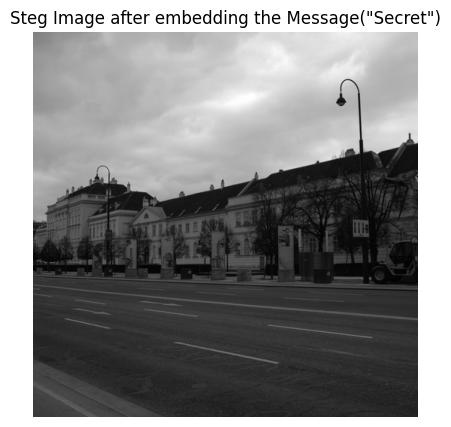

In [ ]:
#Step 5
def embed_message(image_array, message_bits):

    flat_image = image_array.flatten().astype(np.uint8)  # Flatten image and ensure data type is uint8

    # Store the original bits of the image pixels that will be modified
    original_bits = [np.binary_repr(flat_image[i], width=8) for i in range(len(message_bits))]

    # Modify the least significant bit (LSB) of each pixel with message bits
    for i in range(len(message_bits)):
        pixel_value = flat_image[i]  # Get original pixel value
        modified_pixel = (pixel_value & 0b11111110) | int(message_bits[i])  # Apply LSB replacement
        flat_image[i] = np.clip(modified_pixel, 0, 255)  # Prevent overflow beyond uint8

    # Reshape the modified image back to original dimensions
    stego_image = flat_image.reshape(image_array.shape)

    # Output for visualization of modification
    print("The first character of message ('S': 01010011) replaces LSB of first 8 bytes in original image")
    for i in range(8):
        original_val = image_array.flatten()[i]
        modified_val = stego_image.flatten()[i]
        print(f"Pixel {i}: Original Byte: {original_val} ({format(original_val, '08b')}) -> Modified Byte: {modified_val} ({format(modified_val, '08b')})")

    # Display the stego image
    plt.figure(figsize=(5, 5))
    plt.imshow(stego_image, cmap='gray')
    plt.title('Steg Image after embedding the Message("Secret")')
    plt.axis('off')
    plt.show()

    return stego_image

steg_image_array = embed_message(img_array, message_bits)


### Step 6: Show Bit Representation and Histogram of Stego Image

**Purpose:**  
Check how the image looks after hiding the message by showing its binary form and pixel intensity distribution.

**Input:**  
- A stego image (a 2D array of pixel intensity values with a hidden message inside).

**Output:**  
- A printed version of the image showing each pixel as an 8-bit binary value.  
- A histogram that shows how often each pixel value (0–255) appears.

**Description:**  
Once the message is hidden in the image, we take a closer look at what changed:

- **Binary View:** Each pixel’s number (like 128) is shown as an 8-digit binary code (like `10000000`) to visualize the changes in the Least Significant Bits (LSBs).
- **Histogram:** We also plot a graph to see how pixel values are distributed in the stego image. This helps us observe any unusual patterns caused by hiding the message.


Bit Representation of Steg Image Pixel Intensity values in 2D with the size of 512x512:
[['10000000' '10000001' '01111110' ... '10111110' '10111110' '10111101']
 ['10000000' '10000000' '10000000' ... '10111110' '10111110' '10111110']
 ['10000000' '10000001' '10000001' ... '10111111' '10111110' '10111110']
 ...
 ['00111001' '00111001' '00111011' ... '00101110' '00101000' '00100001']
 ['00111011' '00111001' '00111010' ... '00101010' '00101010' '00100010']
 ['00111100' '00110111' '00111001' ... '00100100' '00100100' '00100110']]


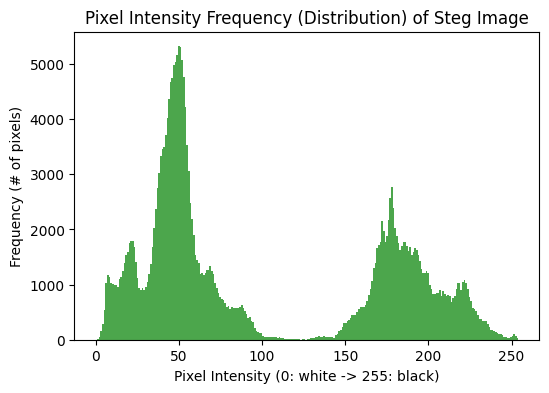

In [ ]:
# Step 6
def show_stego_bit_representation(steg_image_array):
    steg_bit_representation = np.vectorize(np.binary_repr)(steg_image_array, width=8)
    print("Bit Representation of Steg Image Pixel Intensity values in 2D with the size of 512x512:")
    print(steg_bit_representation)

show_stego_bit_representation(steg_image_array)

### Step 7: Extract the Hidden Message from the Stego Image

**Purpose:**  
To retrieve the original secret message that was hidden inside the image.

**Input:**  
- `steg_image_array`: The image that has the hidden message.  
- `length`: The number of bits in the original message.

**Output:**  
- The recovered secret message in text form (e.g., "Secret").

**Description:**  
This step checks the last bit of each pixel in the stego image and collects them.  
The bits are grouped to form letters and then joined to recover the full message.

This shows how a hidden message can be revealed from an image after it was embedded.


In [ ]:
# Step 7:
def extract_message(image_array, length):
    # Flatten the image to access pixel values sequentially
    flat_image = image_array.flatten()

    # Extract the LSBs from the first 'length' pixels (where the message was hidden)
    extracted_bits = ''.join([str(flat_image[i] & 1) for i in range(length)])

    # Convert extracted bits back to characters
    extracted_chars = [chr(int(extracted_bits[i:i+8], 2)) for i in range(0, length, 8)]

    # Reconstruct the original hidden message
    extracted_message = ''.join(extracted_chars)
    return extracted_message

retrieved_message = extract_message(steg_image_array, len(message_bits))
print("\nExtracted Hidden Message:")
print(retrieved_message)



Extracted Hidden Message:
Secret


### Step 8: Compare Histograms to Spot Differences Between Original and Stego Images

**Purpose:**  
To visually detect whether hiding a message changed the pixel distribution in the image.

**Input:**  
- `img_array`: The grayscale pixel values of the original image.  
- `steg_image_array`: The grayscale pixel values of the stego image.

**Output:**  
- Two side-by-side histograms:
  - One for the original image (blue)
  - One for the stego image (green)

**Description:**  
This step shows a direct visual comparison between the original and the stego image by plotting their pixel intensity distributions.

While the two histograms may look very similar, small differences can be spotted:
- Tiny shifts in certain pixel intensity ranges.
- Slight increases or decreases in the number of pixels at specific brightness levels.

These small changes happen because hiding the message modifies some pixel values slightly.  
This visual analysis gives us a first clue that even though the images look the same to the eye, their internal pixel patterns may reveal hidden information.



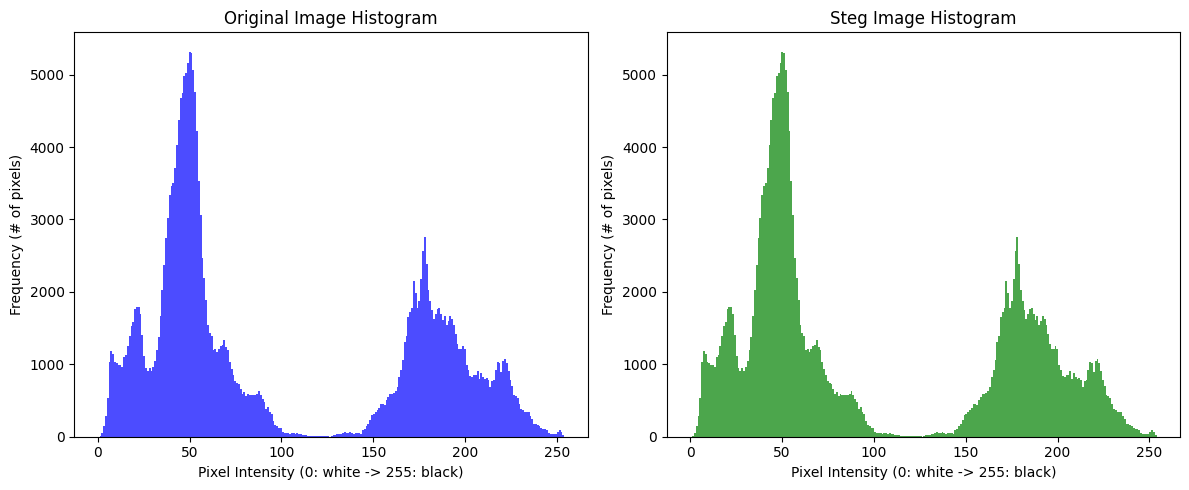

In [ ]:
# Step 8
def compare_original_and_stego_histograms(img_array, steg_image_array):
    plt.figure(figsize=(12, 5))

    # Histogram for original image
    plt.subplot(1, 2, 1)
    plt.hist(img_array.ravel(), bins=256, color='blue', alpha=0.7)
    plt.title('Original Image Histogram')
    plt.xlabel('Pixel Intensity (0: white -> 255: black)')
    plt.ylabel('Frequency (# of pixels)')

    # Histogram for stego image
    plt.subplot(1, 2, 2)
    plt.hist(steg_image_array.ravel(), bins=256, color='green', alpha=0.7)
    plt.title('Steg Image Histogram')
    plt.xlabel('Pixel Intensity (0: white -> 255: black)')
    plt.ylabel('Frequency (# of pixels)')

    plt.tight_layout()
    plt.show()

compare_original_and_stego_histograms(img_array, steg_image_array)

### Step 9: Extract Simple Features to Spot Changes in Basic Image Properties

**Purpose:**  
To detect if hiding a message has slightly altered the image’s brightness, contrast, or edge patterns.

**Input:**  
- `img_array`: Grayscale pixel values of the original image.  
- `steg_image_array`: Grayscale pixel values of the stego image.

**Output:**  
- A table showing a side-by-side comparison of key features from both images.  
- A histogram visualizing how the features differ between the original and stego images.

**Description:**  
This step compares a few important features between the two images:

- **Mean Pixel Intensity**: How bright the overall image is.
- **Standard Deviation**: How much the pixel values vary (contrast).
- **Edge Mean Intensity**: How strong the detected edges are across the image.
- **Edge Standard Deviation**: How much the strength of edges varies in different areas.

By comparing these numbers and looking at the histogram, we can see if the hidden message caused slight shifts.  
For example:
- A small change in mean intensity might suggest pixel values were slightly altered.
- Changes in edge features could hint at subtle distortions introduced during message embedding.

---

### Why Extract Simple Features?

Simple features help machine learning models tell images apart.  
If hiding a message slightly changes these basic properties, a trained AI can use that difference to detect hidden content even when it’s invisible to the human eye.



Extracted Features:
                Feature  Original Image  Stego Image
   Mean Pixel Intensity      100.406746   100.406754
     Standard Deviation       72.437776    72.437780
    Edge Mean Intensity      115.490112   115.494019
Edge Standard Deviation      116.315451   116.315637


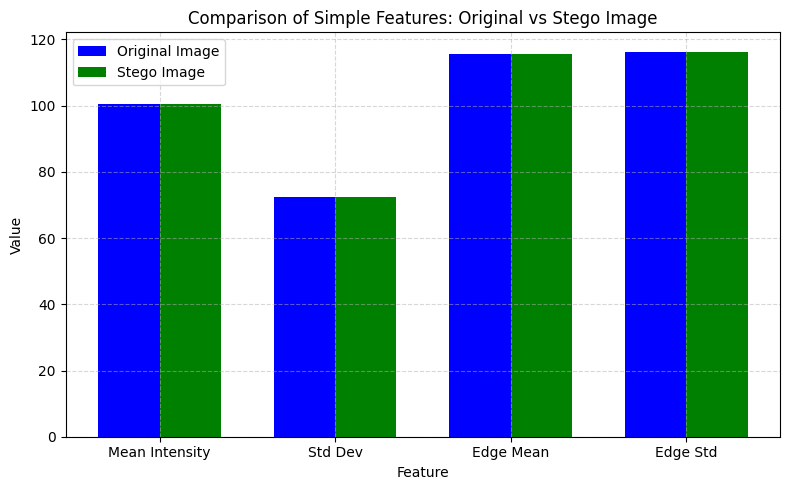

In [ ]:
# Step 9

def extract_and_compare_simple_features(img_array, steg_image_array):

    def simple_feature_extraction(image_array):
        """Extracts basic features such as mean, standard deviation, edge mean, and edge std deviation."""
        features = []

        # Compute Mean and Standard Deviation - Represents overall brightness and contrast of the image
        mean_value = np.mean(image_array)
        std_dev = np.std(image_array)
        features.extend([mean_value, std_dev])

        # Apply Sobel filter for edge detection and compute edge statistics
        edges = sobel(image_array)
        edge_mean = np.mean(edges)
        edge_std = np.std(edges)
        features.extend([edge_mean, edge_std])

        return features

    # Extract features from both original and stego image
    original_features = [float(f) for f in simple_feature_extraction(img_array)]
    stego_features = [float(f) for f in simple_feature_extraction(steg_image_array)]

    # Create and print a structured table of feature values
    df_features = pd.DataFrame({
        "Feature": ["Mean Pixel Intensity", "Standard Deviation", "Edge Mean Intensity", "Edge Standard Deviation"],
        "Original Image": original_features,
        "Stego Image": stego_features
    })
    print("\nExtracted Features:")
    print(df_features.to_string(index=False))

    # Plot a histogram comparing the extracted features
    features_labels = ["Mean Intensity", "Std Dev", "Edge Mean", "Edge Std"]
    x = np.arange(len(features_labels))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, original_features, width, label='Original Image', color='blue')
    plt.bar(x + width/2, stego_features, width, label='Stego Image', color='green')
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.title('Comparison of Simple Features: Original vs Stego Image')
    plt.xticks(x, features_labels)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

extract_and_compare_simple_features(img_array, steg_image_array)

### Step 10: Extract 41 Advanced Features to Better Notice Tiny Differences Between Images


**Purpose:**  
To collect many detailed features from the image so that each image can be described more uniquely.  
By gathering 41 different types of information, we can better tell the difference between two images — even if they look the same to the human eye.  
This helps the AI to more accurately spot whether an image has a hidden message or not.


**Input:**  
- `img_array`: The 2D grayscale pixel array of the original (cover) image.  
- `steg_image_array`: The 2D grayscale pixel array of the stego image (with the message embedded).

**Output:**  
- Two sets of 41 feature values (one for the cover image and one for the stego image).  
- A histogram comparing the values of all 41 features side-by-side.

**Description:**  
This step looks deeper into how an image is structured by computing 41 advanced features. These features are useful for training AI models to tell whether an image contains hidden information.

**What Are These Features?**  

1. **Bit-Plane Correlation**  
   - Measures the similarity between different layers (bits) inside the pixel values.

2. **Auto-Correlation in LSB Plane (14 features)**  
   - Looks at how the LSB values change across neighboring pixels in different directions.

3. **Histogram-Based Features (5 features)**  
   - Compares how often pixel values occur, especially looking at patterns between even vs odd numbers and shifts in pixel intensities.

4. **Wavelet-Based Features (21 features)**  
   - Breaks the image down into parts (using a method called wavelet transform), then checks for structure changes in those parts.

**Visual Output:**  
- A **histogram** with 41 bars for each image:  
   - **Blue** bars = cover image  
   - **Green** bars = stego image  
- Helps visualize how much each feature changes when a message is hidden in the image.

This step gives the AI model powerful information to decide if an image is suspicious.


Extracting 41 Advanced Features for Original Image:
[0.28581011420829383, 0.994805843302637, 0.9900385007102575, 0.9855454173723994, 0.9811153043302294, 0.994025416022309, 0.9888108052690883, 0.9850226970297491, 0.9823747867722996, 0.9909731019418593, 0.9833779329425605, 0.9768130711540618, 0.971506720590671, 0.9864391573650308, 0.9871314849789379, 0.9917548756220705, 0.9920847683857692, 0.9727048407880392, 0.9447500536443505, 0.9103175064134879, -0.10939179422893719, -0.1623358757773946, -0.1646329086801854, 0.08781128799228473, 0.0696040387376669, -0.03313327646920395, 0.01536968342572292, -0.07992151214194027, -0.1481211617373054, -0.19707235197852732, 0.11207110063809181, 0.0907339259513519, -0.05528890169241498, 0.03034916359658132, -0.061454734808061656, -0.14906702669844624, -0.19893069128863866, 0.10937842802430628, 0.08055402960100642, -0.06140547016331502, 0.03318447426776031]

Extracting 41 Advanced Features for Stego Image:
[0.28581011420829383, 0.994805843302637, 0.9900385

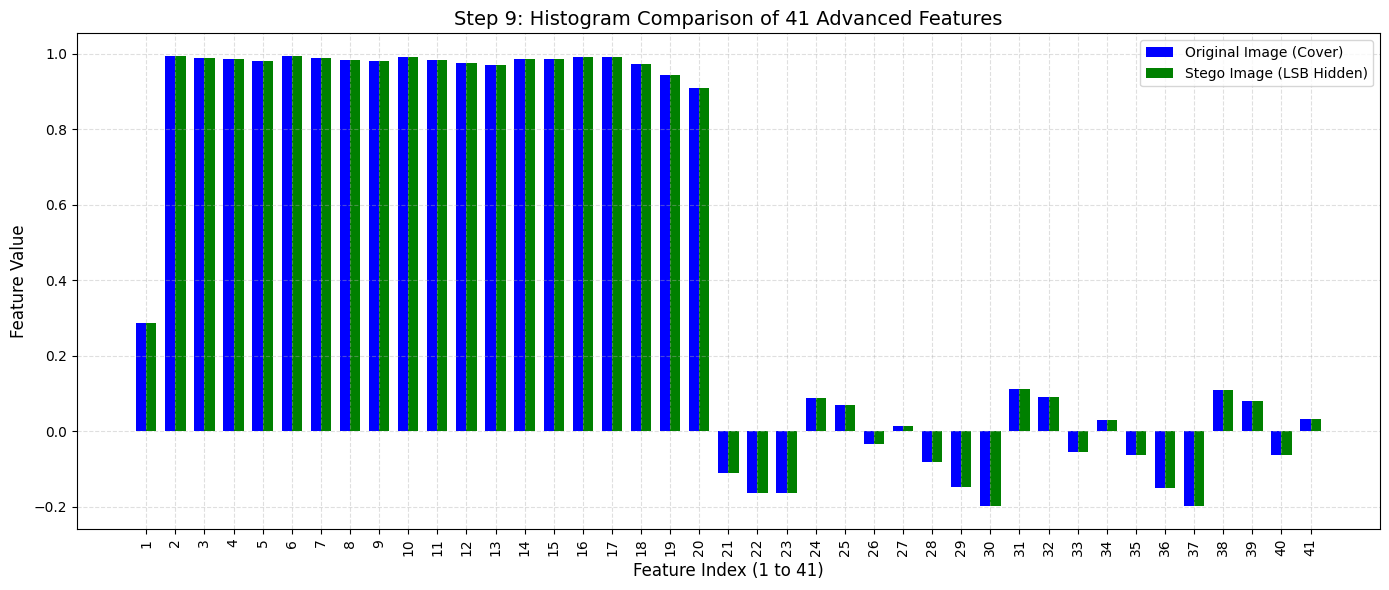

In [ ]:
# Step 10

def extract_and_compare_41_features(img_array, steg_image_array):
    """
    Extracts 41 advanced features from original and stego images, then plots a side-by-side
    bar chart comparing the values with labeled axes and a descriptive title.
    """

    def getBitPlanes(img):
        bin_image = []
        bit_planes = []
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                bin_image.append(np.binary_repr(img[i][j], width=8))
        for i in range(8):
            bit_planes.append(np.array([int(b[i]) for b in bin_image]).reshape(img.shape))
        return bit_planes

    def autocor(A, k, l):
        Xk = A[0:A.shape[0] - k, 0:A.shape[1] - l]
        Xl = A[k:A.shape[0], l:A.shape[1]]
        return pearsonr(Xk.flatten(), Xl.flatten())[0]

    def getModifiedWavelet(C, t):
        C[np.abs(C) < t] = 0
        return C

    def getE(img, t):
        coeffs = pywt.dwt2(img, 'haar')
        LL, (LH, HL, HH) = coeffs
        LH, HL, HH = [getModifiedWavelet(arr, t) for arr in (LH, HL, HH)]
        img_denoised = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
        return img - img_denoised

    def getCE(img, t, k, l):
        E = getE(img, t)
        return autocor(E, k, l)

    def extract_advanced_features_41(image_array):
        features = []
        bit_planes = getBitPlanes(image_array)
        M1, M2 = bit_planes[0], bit_planes[1]
        features.append(pearsonr(M1.flatten(), M2.flatten())[0])
        autocor_kl_pairs = [
            [1, 0], [2, 0], [3, 0], [4, 0], [0, 1], [0, 2], [0, 3], [0, 4],
            [1, 1], [2, 2], [3, 3], [4, 4], [1, 2], [2, 1]
        ]
        for k, l in autocor_kl_pairs:
            features.append(autocor(M1, k, l))
        img_hist, _ = np.histogram(image_array.flatten(), bins=range(257), density=True)
        He, Ho = img_hist[::2], img_hist[1::2]
        features.append(pearsonr(He, Ho)[0])
        for i in range(1, 5):
            Hl1, Hl2 = img_hist[:256 - i], img_hist[i:256]
            features.append(pearsonr(Hl1, Hl2)[0])
        autocor_tkl_triplets = [
            [1.5, 0, 1], [1.5, 1, 0], [1.5, 1, 1], [1.5, 0, 2], [1.5, 2, 0], [1.5, 1, 2], [1.5, 2, 1],
            [2.0, 0, 1], [2.0, 1, 0], [2.0, 1, 1], [2.0, 0, 2], [2.0, 2, 0], [2.0, 1, 2], [2.0, 2, 1],
            [2.5, 0, 1], [2.5, 1, 0], [2.5, 1, 1], [2.5, 0, 2], [2.5, 2, 0], [2.5, 1, 2], [2.5, 2, 1]
        ]
        for t, k, l in autocor_tkl_triplets:
            features.append(getCE(image_array, t, k, l))
        return [float(f) for f in features]

    print("Extracting 41 Advanced Features for Original Image:")
    original_41_features = extract_advanced_features_41(img_array)
    print(original_41_features)

    print("\nExtracting 41 Advanced Features for Stego Image:")
    stego_41_features = extract_advanced_features_41(steg_image_array)
    print(stego_41_features)

    # Plot a bar chart comparing the 41 extracted features
    x = np.arange(1, 42)
    width = 0.35

    plt.figure(figsize=(14, 6))
    plt.bar(x - width/2, original_41_features, width, label='Original Image (Cover)', color='blue')
    plt.bar(x + width/2, stego_41_features, width, label='Stego Image (LSB Hidden)', color='green')
    plt.xlabel('Feature Index (1 to 41)', fontsize=12)
    plt.ylabel('Feature Value', fontsize=12)
    plt.title('Step 9: Histogram Comparison of 41 Advanced Features', fontsize=14)
    plt.xticks(x, [str(i) for i in x], rotation=90)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

extract_and_compare_41_features(img_array, steg_image_array)